In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time


import torchvision
from torchvision import transforms
import torchvision.models as models
from ptflops import get_model_complexity_info

import numpy as np
import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


C:\Users\matth\anaconda3\envs\aiclass\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [33]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5), (0.5))
    ])
ftrain = torchvision.datasets.FashionMNIST("./Data",download=True,transform=transform)
ftest =  torchvision.datasets.FashionMNIST("./Data", download=True, train=False, transform = transform)

ftrn_load = torch.utils.data.DataLoader(ftrain, batch_size = 100,shuffle = True)
ftst_load = torch.utils.data.DataLoader(ftest, batch_size = 100,shuffle = False)


In [7]:
def training(train_loader,test_loader,model,opti,name,num_epoch,lrr=0.0001,wd=0,save_model=0,m=0.9,py1 = 1,py2=28,py3=28):
    t0 = time.time()
    if opti =="CEL":
        criterion = nn.CrossEntropyLoss()
    elif opti =="BCE":
        criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(),lr=lrr,weight_decay = wd, momentum=m)
    
    loss_train_array = torch.zeros(num_epoch)
    acc_training_array = torch.zeros(num_epoch)
    acc_array = torch.zeros(num_epoch)
    
    i=0
    for epoch in range(num_epoch):
        correct_t = 0
        total_t = 60000
        for imgs, labels in ftrn_load:
            imgs,labels = imgs.to(device),labels.to(device)
            batch_size = imgs.shape[0] #takes image data, puts into 0 x data tensor
            outputs = model(imgs)
            #outputs = model(imgs.view(batch_size, -1)) unsqueeze(0) adds dimensionality at dimension 0, (0,1)--> (0,1,2) where 1 is the new dimension
            loss = criterion(outputs,labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        with torch.no_grad():
            for imgss, labelss in ftrn_load:
                imgss,labelss = imgss.to(device),labelss.to(device)
                batch_size = imgss.shape[0] # records size of imgs.shape[0]
                outputss = model(imgss)
                
                #outputss = model(imgss.view(batch_size,-1))
                _,predictedd = torch.max(outputss,dim=1) #
               # total_t += labels.shape[0] #create 
                correct_t += int((predictedd == labelss).sum()) # if predicted is the answer, add it to sum
            #print(correct_t)
            #print(total_t)

        print(" Epoch: %d, Loss: %F" % (epoch, float(loss)))
        print("Training Accuracy: %f" % (correct_t / total_t))
        loss_train_array[i]=float(loss)
        acc_training_array[i]=float(correct_t/total_t)
        
        correct_v = 0
        total_v = 10000
        #val_loss_v = 0
        
        with torch.no_grad():
            for imgs, labels in ftst_load:
                imgs,labels = imgs.to(device),labels.to(device)
                batch_size = imgs.shape[0] # records size of imgs.shape[0]
                outputs = model(imgs)
                #outputs = model(imgs.view(batch_size,-1)) #predicts output class with model, .view changes shape to be batchsize (1D array)
                _,predicted = torch.max(outputs,dim=1) #
               # total_v += labels.shape[0] #create 
                correct_v += int((predicted == labels).sum()) # if predicted is the answer, add it to sum
        #print(correct_v)
        #print(total_v)
        print("Validation Accuracy: ", correct_v / total_v)
        acc_array[i] = correct_v / total_v
        i = i+1
    print(f'training time = {time.time()-t0}')
    plt.plot(range(num_epoch),loss_train_array,color = 'blue',label ='Training Loss')
    plt.plot(range(num_epoch),acc_training_array,color = 'red',label ='Training Accuracy')
    plt.plot(range(num_epoch),acc_array,color = 'green',label ='Validation Accuracy')
    plt.title(f'Fashionmnist')
    plt.xlabel('epoch')
    plt.ylabel('Value')
    with torch.cuda.device(0):
        net = model
        macs, params = get_model_complexity_info(net, ( py1, py2, py3), as_strings=True,
                                           print_per_layer_stat=True, verbose=True) # 1,28,28 is res of each image
        print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
        print('{:<30}  {:<8}'.format('Number of parameters: ', params))
    if save_model == 1:
        torch.save(model.state_dict(), name)

In [34]:
class LeNet_original (nn.Module):
    def __init__(self):
        super().__init__()
        self.LC0 = nn.LazyConv2d(6, kernel_size =5,padding=2)
        self.LC1 = nn.LazyConv2d(16, kernel_size =5,padding=2)
        self.max = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flat = nn.Flatten()
        self.L0 = nn.LazyLinear(120)
        self.L1 = nn.LazyLinear(84)
        self.out = nn.LazyLinear(10)
        self.sig = nn.Sigmoid()
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.LC0(x))
        x = self.max(x)
        x = self.relu(self.LC1(x))
        x = self.max(x)
        x = self.flat(x)
        x = self.relu(self.L0(x))
        x = self.relu(self.L1(x))
        x = self.out(x)
        return x
LeNet_original = LeNet_original()
LeNet_original.to(device)

C:\Users\matth\anaconda3\envs\aiclass\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


LeNet_original(
  (LC0): LazyConv2d(0, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (LC1): LazyConv2d(0, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (L0): LazyLinear(in_features=0, out_features=120, bias=True)
  (L1): LazyLinear(in_features=0, out_features=84, bias=True)
  (out): LazyLinear(in_features=0, out_features=10, bias=True)
  (sig): Sigmoid()
  (relu): ReLU()
)

In [ ]:
training(ftrn_load,ftst_load,LeNet_original,"CEL","1A_model",10,0.1,0,1) # (train,test,model,name,epoch,lr,weightdecay,savemodel(bool))

 Epoch: 0, Loss: 0.300060
Training Accuracy: 0.847767
Validation Accuracy:  0.8369
 Epoch: 1, Loss: 0.305880
Training Accuracy: 0.873550
Validation Accuracy:  0.8555
 Epoch: 2, Loss: 0.383523
Training Accuracy: 0.882867
Validation Accuracy:  0.8663
 Epoch: 3, Loss: 0.263784
Training Accuracy: 0.881667
Validation Accuracy:  0.8627
 Epoch: 4, Loss: 0.207600
Training Accuracy: 0.885850
Validation Accuracy:  0.8666
 Epoch: 5, Loss: 0.192986
Training Accuracy: 0.898200
Validation Accuracy:  0.8787
 Epoch: 6, Loss: 0.352542
Training Accuracy: 0.899500
Validation Accuracy:  0.8785
 Epoch: 7, Loss: 0.372260
Training Accuracy: 0.898200
Validation Accuracy:  0.877
 Epoch: 8, Loss: 0.258593
Training Accuracy: 0.895383
Validation Accuracy:  0.8743


In [26]:
#PROBLEM B1

class LeNet (nn.Module):
    def __init__(self):
        super().__init__()
        self.LC0 = nn.Conv2d(1,6, kernel_size =5,padding=2, groups = 1)
        self.LC1 = nn.Conv2d(6,16, kernel_size =5,padding=2,groups = 1)
        self.LC2 = nn.Conv2d(16,36, kernel_size =5,padding=2, groups = 1)
        self.max = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flat = nn.Flatten()
        self.L0 = nn.Linear(324,196)
        self.L1 = nn.Linear(196,49)
        #self.L2 = nn.Linear(40,20)
        self.out = nn.Linear(49,10)
        self.sig = nn.Sigmoid()
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.LC0(x))
        x = self.max(x)
        x = self.relu(self.LC1(x))
        x = self.max(x)
        x = self.relu(self.LC2(x))
        x = self.max(x)
        x = self.flat(x)
        x = self.relu(self.L0(x))
        x = self.relu(self.L1(x))
        #x = self.relu(self.L2(x))
        x = self.out(x)
        return x
LeNet = LeNet()
LeNet.to(device)



LeNet(
  (LC0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (LC1): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (LC2): Conv2d(16, 36, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (L0): Linear(in_features=324, out_features=196, bias=True)
  (L1): Linear(in_features=196, out_features=49, bias=True)
  (L2): Linear(in_features=40, out_features=20, bias=True)
  (out): Linear(in_features=49, out_features=10, bias=True)
  (sig): Sigmoid()
  (relu): ReLU()
)

47878
60000
 Epoch: 0, Loss: 0.499979
Training Accuracy: 0.797967
7915
10000
Validation Accuracy:  0.7915
51488
60000
 Epoch: 1, Loss: 0.397353
Training Accuracy: 0.858133
8478
10000
Validation Accuracy:  0.8478
52600
60000
 Epoch: 2, Loss: 0.336601
Training Accuracy: 0.876667
8662
10000
Validation Accuracy:  0.8662
53358
60000
 Epoch: 3, Loss: 0.298185
Training Accuracy: 0.889300
8743
10000
Validation Accuracy:  0.8743
53983
60000
 Epoch: 4, Loss: 0.352478
Training Accuracy: 0.899717
8845
10000
Validation Accuracy:  0.8845
54119
60000
 Epoch: 5, Loss: 0.226771
Training Accuracy: 0.901983
8847
10000
Validation Accuracy:  0.8847
53982
60000
 Epoch: 6, Loss: 0.228206
Training Accuracy: 0.899700
8816
10000
Validation Accuracy:  0.8816
54365
60000
 Epoch: 7, Loss: 0.214694
Training Accuracy: 0.906083
8879
10000
Validation Accuracy:  0.8879
54965
60000
 Epoch: 8, Loss: 0.298171
Training Accuracy: 0.916083
8932
10000
Validation Accuracy:  0.8932
55354
60000
 Epoch: 9, Loss: 0.178790
Training

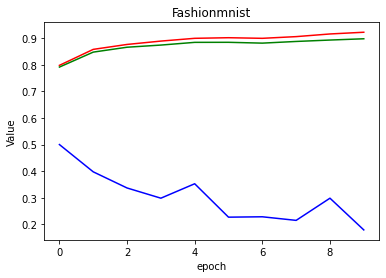

In [27]:
training(ftrn_load,ftst_load,LeNet,"CEL","1B_model", 10,0.01,0.0001,1)

In [30]:
# PROBLEM B2

class LeNet (nn.Module):
    def __init__(self):
        super().__init__()
        self.LC0 = nn.Conv2d(1,6, kernel_size =5,padding=2, groups = 1)
        self.LC1 = nn.Conv2d(6,16, kernel_size =5,padding=2,groups = 1)
        #self.LC2 = nn.Conv2d(16,36, kernel_size =5,padding=2, groups = 1)
        self.max = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flat = nn.Flatten()
        self.L0 = nn.Linear(784,196)
        self.L1 = nn.Linear(196,49)
        #self.L2 = nn.Linear(40,20)
        self.out = nn.Linear(49,10)
        self.sig = nn.Sigmoid()
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.LC0(x))
        x = self.max(x)
        x = self.relu(self.LC1(x))
        x = self.max(x)
        #x = self.relu(self.LC2(x))
        #x = self.max(x)
        x = self.flat(x)
        x = self.relu(self.L0(x))
        x = self.relu(self.L1(x))
        #x = self.relu(self.L2(x))
        x = self.out(x)
        return x
LeNet = LeNet()
LeNet.to(device)

LeNet(
  (LC0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (LC1): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (L0): Linear(in_features=784, out_features=196, bias=True)
  (L1): Linear(in_features=196, out_features=49, bias=True)
  (out): Linear(in_features=49, out_features=10, bias=True)
  (sig): Sigmoid()
  (relu): ReLU()
)

50178
60000
 Epoch: 0, Loss: 0.362786
Training Accuracy: 0.836300
8315
10000
Validation Accuracy:  0.8315
52005
60000
 Epoch: 1, Loss: 0.277438
Training Accuracy: 0.866750
8562
10000
Validation Accuracy:  0.8562
52855
60000
 Epoch: 2, Loss: 0.238539
Training Accuracy: 0.880917
8720
10000
Validation Accuracy:  0.872
53788
60000
 Epoch: 3, Loss: 0.295935
Training Accuracy: 0.896467
8818
10000
Validation Accuracy:  0.8818
53830
60000
 Epoch: 4, Loss: 0.284499
Training Accuracy: 0.897167
8816
10000
Validation Accuracy:  0.8816
54548
60000
 Epoch: 5, Loss: 0.165657
Training Accuracy: 0.909133
8940
10000
Validation Accuracy:  0.894
55132
60000
 Epoch: 6, Loss: 0.128925
Training Accuracy: 0.918867
9024
10000
Validation Accuracy:  0.9024
54975
60000
 Epoch: 7, Loss: 0.275057
Training Accuracy: 0.916250
8961
10000
Validation Accuracy:  0.8961
55275
60000
 Epoch: 8, Loss: 0.175408
Training Accuracy: 0.921250
8985
10000
Validation Accuracy:  0.8985
55845
60000
 Epoch: 9, Loss: 0.194089
Training A

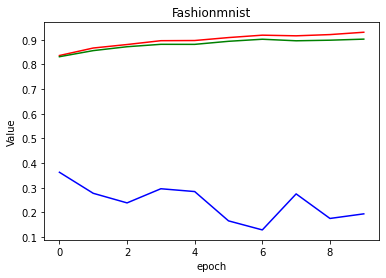

In [31]:
training(ftrn_load,ftst_load,LeNet,"CEL","1B_model", 10,0.01,0.0001,1)

In [7]:
# PROBLEM B3

class LeNet (nn.Module):
    def __init__(self):
        super().__init__()
        self.LC0 = nn.Conv2d(1,6, kernel_size =5,padding=2, groups = 1)
        self.LC1 = nn.Conv2d(6,12, kernel_size =5,padding=2,groups = 1)
       
        self.max = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flat = nn.Flatten()
        
        self.L0 = nn.Linear(588,296)
        self.L1 = nn.Linear(296,149)
        self.L2 = nn.Linear(149,75)
        self.out = nn.Linear(75,10)
        
        self.sig = nn.Sigmoid()
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.LC0(x))
        x = self.max(x)
        x = self.relu(self.LC1(x))
        x = self.max(x)
        x = self.flat(x)
        x = self.relu(self.L0(x))
        x = self.relu(self.L1(x))
        x = self.relu(self.L2(x))
        x = self.out(x)
        return x
LeNet = LeNet()
LeNet.to(device)

LeNet(
  (LC0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (LC1): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (L0): Linear(in_features=588, out_features=296, bias=True)
  (L1): Linear(in_features=296, out_features=149, bias=True)
  (L2): Linear(in_features=149, out_features=75, bias=True)
  (out): Linear(in_features=75, out_features=10, bias=True)
  (sig): Sigmoid()
  (relu): ReLU()
)

 Epoch: 0, Loss: 0.135459
Training Accuracy: 0.937000
Validation Accuracy:  0.9131
 Epoch: 1, Loss: 0.150064
Training Accuracy: 0.937883
Validation Accuracy:  0.9126
 Epoch: 2, Loss: 0.238176
Training Accuracy: 0.939350
Validation Accuracy:  0.9126
 Epoch: 3, Loss: 0.142414
Training Accuracy: 0.940583
Validation Accuracy:  0.9139
 Epoch: 4, Loss: 0.172382
Training Accuracy: 0.941850
Validation Accuracy:  0.9139
 Epoch: 5, Loss: 0.073973
Training Accuracy: 0.942117
Validation Accuracy:  0.9144
 Epoch: 6, Loss: 0.127705
Training Accuracy: 0.944083
Validation Accuracy:  0.9154
 Epoch: 7, Loss: 0.188982
Training Accuracy: 0.944767
Validation Accuracy:  0.9144
 Epoch: 8, Loss: 0.158631
Training Accuracy: 0.944633
Validation Accuracy:  0.9143
 Epoch: 9, Loss: 0.125285
Training Accuracy: 0.946617
Validation Accuracy:  0.9162
training time = 177.81541180610657
LeNet(
  232.57 k, 100.000% Params, 722.7 KMac, 100.000% MACs, 
  (LC0): Conv2d(156, 0.067% Params, 122.3 KMac, 16.923% MACs, 1, 6, ker

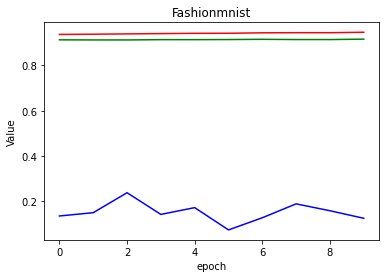

In [64]:
training(ftrn_load,ftst_load,LeNet,"CEL","1B_model", 10,0.01,0.0001,0)

In [68]:
class LeNet_drop (nn.Module):
    def __init__(self):
        super().__init__()
        self.LC0 = nn.Conv2d(1,6, kernel_size =5,padding=2, groups = 1)
        self.LC1 = nn.Conv2d(6,12, kernel_size =5,padding=2,groups = 1)
        
        self.max = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flat = nn.Flatten()
        self.L0 = nn.Linear(588,296)
        self.L1 = nn.Linear(296,149)
        self.L2 = nn.Linear(149,75)
        self.out = nn.Linear(75,10)
        self.sig = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.drop1 = nn.Dropout(0.5)
        self.drop2 = nn.Dropout(0.5)
    def forward(self, x):
        x = self.relu(self.LC0(x))
        x = self.max(x)
        x = self.relu(self.LC1(x))
        x = self.max(x)
        x = self.flat(x)
        x = self.relu(self.L0(x))
        x = self.drop1(x)
        x = self.relu(self.L1(x))
        x = self.drop2(x)
        x = self.relu(self.L2(x))
        x = self.out(x)
        return x
LeNet_drop = LeNet_drop()
LeNet_drop.to(device)

LeNet_drop(
  (LC0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (LC1): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (L0): Linear(in_features=588, out_features=296, bias=True)
  (L1): Linear(in_features=296, out_features=149, bias=True)
  (L2): Linear(in_features=149, out_features=75, bias=True)
  (out): Linear(in_features=75, out_features=10, bias=True)
  (sig): Sigmoid()
  (relu): ReLU()
  (drop1): Dropout(p=0.5, inplace=False)
  (drop2): Dropout(p=0.5, inplace=False)
)

 Epoch: 0, Loss: 0.159196
Training Accuracy: 0.918600
Validation Accuracy:  0.8953
 Epoch: 1, Loss: 0.296273
Training Accuracy: 0.929567
Validation Accuracy:  0.9047
 Epoch: 2, Loss: 0.189184
Training Accuracy: 0.934667
Validation Accuracy:  0.9036
 Epoch: 3, Loss: 0.138516
Training Accuracy: 0.937250
Validation Accuracy:  0.9039
 Epoch: 4, Loss: 0.104706
Training Accuracy: 0.943717
Validation Accuracy:  0.9063
 Epoch: 5, Loss: 0.225670
Training Accuracy: 0.950683
Validation Accuracy:  0.9076
 Epoch: 6, Loss: 0.160955
Training Accuracy: 0.948933
Validation Accuracy:  0.9007
 Epoch: 7, Loss: 0.056393
Training Accuracy: 0.954500
Validation Accuracy:  0.907
 Epoch: 8, Loss: 0.098671
Training Accuracy: 0.958550
Validation Accuracy:  0.9039
 Epoch: 9, Loss: 0.203518
Training Accuracy: 0.959533
Validation Accuracy:  0.9051
training time = 180.1599462032318
LeNet_drop(
  232.57 k, 100.000% Params, 722.7 KMac, 100.000% MACs, 
  (LC0): Conv2d(156, 0.067% Params, 122.3 KMac, 16.923% MACs, 1, 6, 

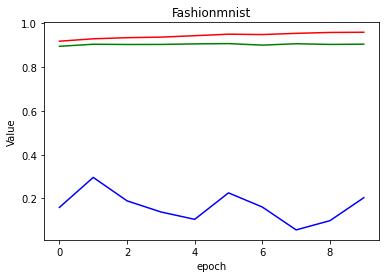

In [70]:
#p3
training(ftrn_load,ftst_load,LeNet_drop,"CEL","1C_model",10,0.01,0.0001,1)

In [17]:
Atransform = transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
ftrain = torchvision.datasets.FashionMNIST("./Data",download=True,transform = Atransform)
ftest =  torchvision.datasets.FashionMNIST("./Data", download=True, train=False, transform = Atransform)

ftrn_load = torch.utils.data.DataLoader(ftrain, batch_size = 100,shuffle = True)
ftst_load = torch.utils.data.DataLoader(ftest, batch_size = 100,shuffle = True)

In [29]:
#p4 ALEX

class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.C0 = nn.Conv2d(1, 24, kernel_size=11, stride=4, padding=1)
        self.C1 = nn.Conv2d(24,64,kernel_size=5,padding=2)
        self.C2 = nn.Conv2d(64,96,kernel_size=3,padding=1)
        #self.C3 = nn.Conv2d(96,96,kernel_size=3,padding=1)
        self.C4 = nn.Conv2d(96,32,kernel_size=3,padding=1)
        
        self.max=nn.MaxPool2d(kernel_size = 3, stride = 2)
        self.flat = nn.Flatten()
        
        self.L0 = nn.Linear(32*6*6,509)
        self.L1 = nn.Linear(509,102)
        self.out = nn.Linear(102,10)
        
        
        self.relu=nn.ReLU()
        self.drop1 = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.relu(self.C0(x))
        x = self.max(x)
        x = self.relu(self.C1(x))
        x = self.max(x)
        x = self.relu(self.C2(x))
        #x = self.relu(self.C3(x))
        x = self.relu(self.C4(x))
        x = self.max(x)
        x = self.flat(x)
        x = self.relu(self.L0(x))
        x = self.drop1(x)
        x = self.relu(self.L1(x))
        x = self.drop1(x)
        x = self.out(x)
        return x
AlexNet = AlexNet()
AlexNet.to(device)



AlexNet(
  (C0): Conv2d(1, 24, kernel_size=(11, 11), stride=(4, 4))
  (C1): Conv2d(24, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (C2): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (C4): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (L0): Linear(in_features=1152, out_features=509, bias=True)
  (L1): Linear(in_features=509, out_features=102, bias=True)
  (out): Linear(in_features=102, out_features=10, bias=True)
  (relu): ReLU()
  (drop1): Dropout(p=0.5, inplace=False)
)

 Epoch: 0, Loss: 0.324243
Training Accuracy: 0.837150
Validation Accuracy:  0.8286
 Epoch: 1, Loss: 0.258973
Training Accuracy: 0.864233
Validation Accuracy:  0.8525
 Epoch: 2, Loss: 0.188174
Training Accuracy: 0.869100
Validation Accuracy:  0.8601
 Epoch: 3, Loss: 0.316767
Training Accuracy: 0.894167
Validation Accuracy:  0.8843
 Epoch: 4, Loss: 0.222248
Training Accuracy: 0.904450
Validation Accuracy:  0.8932
 Epoch: 5, Loss: 0.451734
Training Accuracy: 0.912367
Validation Accuracy:  0.898
 Epoch: 6, Loss: 0.202080
Training Accuracy: 0.914667
Validation Accuracy:  0.9013
 Epoch: 7, Loss: 0.141247
Training Accuracy: 0.919133
Validation Accuracy:  0.9043
 Epoch: 8, Loss: 0.275051
Training Accuracy: 0.923517
Validation Accuracy:  0.9043
 Epoch: 9, Loss: 0.271827
Training Accuracy: 0.929517
Validation Accuracy:  0.9104
training time = 855.8551740646362


RuntimeError: Given input size: (24x1x1). Calculated output size: (24x0x0). Output size is too small

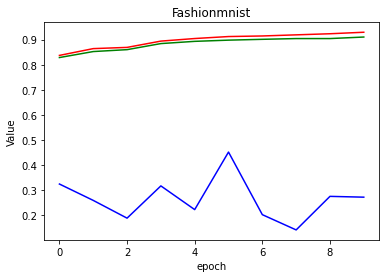

In [31]:
training(ftrn_load,ftst_load,AlexNet,"CEL","P4_model",10,0.01,0.0001,1,0.9,1,11,11)

In [32]:
torch.save(AlexNet.state_dict(), "P4_model")